<a href="https://colab.research.google.com/github/praveen-science/steel-defect-detection/blob/master/TLUNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Notes


###Questions



1.  Dataset in the zip file is a subset of original data



### TO do

- [x] Understand data
- [x] Decide fold structure
-  Write Data generator
    - [x] Get data and labels and masks
- Architecture
    - [x] Unet coding
    - [x] Unet with pre-trained model
- [x] Training loop
- [x] Net training and fine tuning
- [x] Evaluation
- Paper writing
     - [x] Intro
     - [x] Proposed method
     - [ ] Experimental setup and dataset
     - [ ] Results and discussion
     - [ ] Conclusion


## Import stuff

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import pdb
import time
import warnings
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensor
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp
import logging

warnings.filterwarnings("ignore")
seed = 69
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

     |████████████████████████████████| 71kB 5.4MB/s 
     |████████████████████████████████| 245kB 13.4MB/s 
     |████████████████████████████████| 61kB 8.7MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12421 sha256=f4c3ea9f30b43de5775f59462f82ea1ef56f511d27ab348f4e8a1358b1eb22dc
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60963 sha256=b21f9f8c1801ac742f8cc9b9caeee0c69c1a05e884653366135351f4af498a05
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built efficientnet-pytorch pretrainedmodels


# Data Preparation

### Extract data

In [ ]:
import zipfile
import os
if not os.path.isdir('targetdir/'):
  with zipfile.ZipFile("/content/drive/MyDrive/Freelance/FL_Lakshmi/severstal-steel-defect-detection.zip","r") as zip_ref:
      zip_ref.extractall("targetdir")

data__dir='/content/targetdir/'

## Check percentage

In [ ]:
metdata=pd.read_csv('/content/targetdir/train.csv');
metdata.head()
metdata = metdata.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')
metdata['defects'] = metdata.count(axis=1)

df_train, df_validate, df_test = np.split(metdata.sample(frac=1, random_state=42), [int(.8*len(metdata)), int(.9*len(metdata))])
print(len(df_train),len(df_validate),len(df_test))

#train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["defects"], random_state=seed)

5332 667 667


## Data Augmentation

In [ ]:
#https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def mask2rle(img):
    '''
    img: numpy array, 1 -> mask, 0 -> background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def make_mask(row_id, df):
    '''Given a row index, return image_id and mask (256, 1600, 4) from the dataframe `df`'''
    fname = df.iloc[row_id].name
    labels = df.iloc[row_id][:4]
    masks = np.zeros((256, 1600, 4), dtype=np.float32) # float32 is V.Imp
    # 4:class 1～4 (ch:0～3)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            mask = np.zeros(256 * 1600, dtype=np.uint8)
            for pos, le in zip(positions, length):
                mask[pos:(pos + le)] = 1
            masks[:, :, idx] = mask.reshape(256, 1600, order='F')
    return fname, masks

class SteelDataset(Dataset):
    def __init__(self, df, data_folder, mean, std, phase,use_trans=True):
        self.df = df
        self.root = data_folder
        self.mean = mean
        self.std = std
        self.phase = phase
        self.transforms = get_transforms(phase, mean, std)
        self.use_trans=use_trans;
        self.fnames = self.df.index.tolist()

    def __getitem__(self, idx):
        #print(idx)
        image_id, mask = make_mask(idx, self.df)
        image_path = os.path.join(self.root, "train_images",  image_id)
        img = cv2.imread(image_path)
        #print(image_path)
        if(self.use_trans):
          augmented = self.transforms(image=img, mask=mask)
          img = augmented['image']
          mask = augmented['mask'] # 1x256x1600x4
          mask = mask[0].permute(2, 0, 1) # 4x256x1600
        else:
          img=torch.tensor(img)
          mask=torch.tensor(mask)
          mask = mask.permute(2, 0, 1) # 4x256x1600

        return img, mask

    def __len__(self):
        return len(self.fnames)


def get_transforms(phase, mean, std):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
                HorizontalFlip(p=0.5), # only horizontal flip as of now
            ]
        )
    list_transforms.extend(
        [
            Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms

def provider(
    data_folder,
    df_path,
    phase,
    mean=None,
    std=None,
    batch_size=8,
    num_workers=4,
    percentage=1.0,
):
    '''Returns dataloader for the model training'''
    df = pd.read_csv(df_path)
    # https://www.kaggle.com/amanooo/defect-detection-starter-u-net
    #df['ImageId'], df['ClassId'] = zip(*df['ImageId_ClassId'].str.split('_'))
    #df['ClassId'] = df['ClassId'].astype(int)
    df = df.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')
    df['defects'] = df.count(axis=1)
    #print(df.shape)
    train_df, test_val_df = train_test_split(df, test_size=0.25, stratify=df["defects"], random_state=69)
    #print(train_df.shape)
    L=round(percentage*train_df.shape[0])
    train_df=train_df.iloc[0:L,:]
    val_df, test_df = train_test_split(test_val_df, test_size=0.5, random_state=69)
    #print(train_df.shape,val_df.shape,test_df.shape)


    df = train_df if phase == "train" else val_df
    shuffle = True if phase == "train" else False
    image_dataset = SteelDataset(df, data_folder, mean, std, phase)
    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=shuffle,
    )

    return dataloader

# test data gen
'''
input_dir_Train = "/content/targetdir/train_images/"
train_df_path='/content/targetdir/train.csv'
val_dataloader = provider(input_dir_Train,train_df_path,'train')

index = 100
f, m = make_mask(0, df_train)
print('file name : {}'.format(f))
plt.imshow(cv2.imread(os.path.join(input_dir_Train, f)))
plt.show()
plt.imshow(m[:,:,0])
plt.show()
plt.imshow(m[:,:,1])
plt.show()
plt.imshow(m[:,:,2])
plt.show()
plt.imshow(m[:,:,3])
plt.show()
'''

'\ninput_dir_Train = "/content/targetdir/train_images/"\ntrain_df_path=\'/content/targetdir/train.csv\'\nval_dataloader = provider(input_dir_Train,train_df_path,\'train\')\n\nindex = 100\nf, m = make_mask(0, df_train)\nprint(\'file name : {}\'.format(f))\nplt.imshow(cv2.imread(os.path.join(input_dir_Train, f)))\nplt.show()\nplt.imshow(m[:,:,0])\nplt.show()\nplt.imshow(m[:,:,1])\nplt.show()\nplt.imshow(m[:,:,2])\nplt.show()\nplt.imshow(m[:,:,3])\nplt.show()\n'

# Metrics

In [ ]:
def predict(X, threshold):
    '''X is sigmoid output of the model'''
    X_p = np.copy(X)
    preds = (X_p > threshold).astype('uint8')
    return preds

def metric(probability, truth, threshold=0.5, reduction='none'):
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

#         dice_neg = np.nan_to_num(dice_neg.mean().item(), 0)
#         dice_pos = np.nan_to_num(dice_pos.mean().item(), 0)
#         dice = dice.mean().item()

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice, dice_neg, dice_pos, num_neg, num_pos

class Meter:
    '''A meter to keep track of iou and dice scores throughout an epoch'''
    def __init__(self, phase, epoch):
        self.base_threshold = 0.5 # <<<<<<<<<<< here's the threshold
        self.base_dice_scores = []
        self.dice_neg_scores = []
        self.dice_pos_scores = []
        self.iou_scores = []
        self.accuracy =[];

    def update(self, targets, outputs,class_logits):
        class_prob=torch.sigmoid(class_logits)
        probs = torch.sigmoid(outputs)
        dice, dice_neg, dice_pos, _, _ = metric(probs, targets, self.base_threshold)
        self.base_dice_scores.extend(dice.tolist())
        self.dice_pos_scores.extend(dice_pos.tolist())
        self.dice_neg_scores.extend(dice_neg.tolist())
        preds = predict(probs, self.base_threshold)
        iou = compute_iou_batch(preds, targets, classes=[1])
        self.iou_scores.append(iou)
        label= (torch.sum(targets,dim=(2,3))>0).float()
        acc=compute_accuracy_batch(class_prob,label)
        self.accuracy.append(acc)

    def get_metrics(self):
        dice = np.nanmean(self.base_dice_scores)
        dice_neg = np.nanmean(self.dice_neg_scores)
        dice_pos = np.nanmean(self.dice_pos_scores)
        dices = [dice, dice_neg, dice_pos]
        iou = np.nanmean(self.iou_scores)
        acc=np.nanmean(self.accuracy)
        return dices, iou, acc

def epoch_log(phase, epoch, epoch_loss, meter, start):
    '''logging the metrics at the end of an epoch'''
    dices, iou,acc = meter.get_metrics()
    dice, dice_neg, dice_pos = dices
    print("Loss: %0.4f | IoU: %0.4f | dice: %0.4f | dice_neg: %0.4f | dice_pos: %0.4f | accuracy: %0.2f" % (epoch_loss, iou, dice, dice_neg, dice_pos,acc))
    return dice, iou, acc

def compute_accuracy_batch(class_prob,labels):
    class_prob[class_prob >= 0.5] = 1
    class_prob[class_prob <0.5] =0
    accuracy = 100*(class_prob == labels).sum()/(class_prob.shape[0]*class_prob.shape[1])
    return accuracy

def compute_ious(pred, label, classes, ignore_index=255, only_present=True):
    '''computes iou for one ground truth mask and predicted mask'''
    pred[label == ignore_index] = 0
    ious = []
    for c in classes:
        label_c = label == c
        if only_present and np.sum(label_c) == 0:
            ious.append(np.nan)
            continue
        pred_c = pred == c
        intersection = np.logical_and(pred_c, label_c).sum()
        union = np.logical_or(pred_c, label_c).sum()
        if union != 0:
            ious.append(intersection / union)
    return ious if ious else [1]

def compute_iou_batch(outputs, labels, classes=None):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    preds = np.copy(outputs) # copy is imp
    labels = np.array(labels) # tensor to np
    for pred, label in zip(preds, labels):
        ious.append(np.nanmean(compute_ious(pred, label, classes)))
    iou = np.nanmean(ious)
    return iou

# Training loop

In [ ]:
class Trainer(object):
    '''This class takes care of training and validation of our model'''
    def __init__(self, model,percentage=1.0):
        self.num_workers = 6
        self.run_name=run_name
        self.batch_size = {"train": 5, "val": 1}
        self.accumulation_steps = 32 // self.batch_size['train']
        self.lr = 5e-4
        self.num_epochs = 50
        self.best_loss = float("inf")
        self.phases = ["train", "val"]
        self.device = torch.device("cuda:0")
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        self.net = model
        self.criterion = torch.nn.BCEWithLogitsLoss()
        self.criterion_bce = torch.nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", patience=3, verbose=True)
        self.net = self.net.to(self.device)
        cudnn.benchmark = True
        self.dataloaders = {
            phase: provider(
                data_folder=data_folder,
                df_path=train_df_path,
                phase=phase,
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                batch_size=self.batch_size[phase],
                num_workers=self.num_workers,percentage=percentage
            )
            for phase in self.phases
        }
        self.losses = {phase: [] for phase in self.phases}
        self.iou_scores = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        self.accuracy = {phase: [] for phase in self.phases}
        self.class_loss = {phase: [] for phase in self.phases}

    def forward(self, images, targets):
        label= (torch.sum(targets,dim=(2,3))>0).float().to(self.device)
        images = images.to(self.device)
        masks = targets.to(self.device)
        outputs, out_label = self.net(images)
        loss_seg = self.criterion(outputs, masks)
        loss_class = self.criterion_bce(out_label,label)
        #print(out_label.shape,label.shape)
        return loss_seg,loss_class, outputs,out_label

    def iterate(self, epoch, phase):
        meter = Meter(phase, epoch)
        start = time.strftime("%H:%M:%S")
        print(f"Starting epoch: {epoch} | phase: {phase} | ⏰: {start}")
        batch_size = self.batch_size[phase]
        self.net.train(phase == "train")
        dataloader = self.dataloaders[phase]
        running_loss = 0.0
        total_batches = len(dataloader)
        tk0 = tqdm(dataloader, total=total_batches)
        self.optimizer.zero_grad()
        for itr, batch in enumerate(tk0): # replace `dataloader` with `tk0` for tqdm
            images, targets = batch
            loss_seg,loss_class, outputs,out_label = self.forward(images, targets)
            loss_seg = loss_seg / self.accumulation_steps
            loss_class = loss_class / self.accumulation_steps
            loss=loss_seg+loss_class
            if phase == "train":
                loss.backward()
                if (itr + 1 ) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            outputs = outputs.detach().cpu()
            out_label = out_label.detach().cpu()
            meter.update(targets, outputs, out_label)
            tk0.set_postfix(loss=(running_loss / ((itr + 1))))
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        dice, iou,acc = epoch_log(phase, epoch, epoch_loss, meter, start)
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(dice)
        self.iou_scores[phase].append(iou)
        self.accuracy[phase].append(acc)
        torch.cuda.empty_cache()
        return epoch_loss

    def save_valimages(self, filepath):
        state=torch.load(self.run_name+"best_model.pth", map_location=torch.device(self.device))
        self.net.load_state_dict(state["state_dict"]);
        phase='val'
        self.net.train(phase == "train")
        dataloader = self.dataloaders[phase]
        running_loss = 0.0
        total_batches = len(dataloader)
        dice=[]
        iou=[];
        gt_label=[];
        pred=[];
        #self.optimizer.zero_grad()
        for itr, batch in tqdm(enumerate(dataloader)): # replace `dataloader` with `tk0` for tqdm
            images, targets = batch
            loss_seg,loss_class, outputs,out_label = self.forward(images, targets)
            outputs = torch.sigmoid(outputs)

            out_label = out_label.detach().cpu()
            tmp,_,_,_,_=metric(outputs.to(self.device),targets.to(self.device))
            gt_label.append((torch.sum(targets,dim=(2,3))>0).float().numpy())

            #print(tmp[0][0].cpu().numpy())
            dice.append(tmp[0][0].cpu().numpy())

            outputs=outputs.detach().cpu().numpy()
            pred.append(out_label.detach().cpu().numpy())
            targets = targets.detach().cpu().numpy()
            preds = predict(outputs, 0.5)
            tmp2 = compute_iou_batch(preds,targets, classes=[1])
            #print(tmp2)
            iou.append(tmp2)
            '''
            plt.subplot(311)
            plt.imshow(np.squeeze(images).permute(1,2,0))
            plt.title(str(dice))
            plt.subplot(312)
            tt=0.25*targets[0,0,:,:]+(0.25+0.25*targets[0,1,:,:])+(0.5+0.25*targets[0,2,:,:])+(0.75+0.25*targets[0,3,:,:])
            plt.imshow(tt)
            plt.subplot(313)
            tt=0.25*outputs[0,0,:,:]+(0.25+0.25*outputs[0,1,:,:])+(0.5+0.25*outputs[0,2,:,:])+(0.75+0.25*outputs[0,3,:,:])
            plt.imshow(tt)
            plt.savefig(filepath+str(itr)+'_'+f"{tmp[0][0].cpu().numpy():.3f}"+'.png')
            '''
        return dice,iou,pred,gt_label


    def GetPredictions(self, inds,name='hi'):
        state=torch.load(self.run_name+"best_model.pth", map_location=torch.device(self.device))
        self.net.load_state_dict(state["state_dict"]);
        phase='val'
        self.net.train(phase == "train")
        dataloader = iter(self.dataloaders[phase])
        running_loss = 0.0
        total_batches = len(dataloader)
        dice=[]
        iou=[];
        #self.optimizer.zero_grad()
        for j in range(inds):
            images, targets = next(dataloader)

        images, targets = next(dataloader)
        loss_seg,loss_class, outputs,out_label = self.forward(images, targets)
        outputs = torch.sigmoid(outputs)

        out_label = out_label.detach().cpu()
        tmp,_,_,_,_=metric(outputs.to(self.device),targets.to(self.device))

        #print(tmp[0][0].cpu().numpy())
        dice.append(tmp[0][0].cpu().numpy())

        outputs=outputs.detach().cpu().numpy()
        targets = targets.detach().cpu().numpy()
        preds = predict(outputs, 0.5)
        tmp2 = compute_iou_batch(preds,targets, classes=[1])
        #print(tmp2)
        iou.append(tmp2)
        scipy.io.savemat(name+'_'+str(inds)+'.mat',{'outputs':outputs,'targets':targets,'dice':tmp[0][0].cpu().numpy(),'input':images.detach().cpu().numpy()})
        plt.subplot(311)
        plt.imshow(np.squeeze(images).permute(1,2,0))
        plt.title(str(dice))
        plt.subplot(312)
        tt=0.25*targets[0,0,:,:]+(0.25+0.25*targets[0,1,:,:])+(0.5+0.25*targets[0,2,:,:])+(0.75+0.25*targets[0,3,:,:])
        plt.imshow(tt)
        plt.subplot(313)
        tt=0.25*preds[0,0,:,:]+(0.25+0.25*preds[0,1,:,:])+(0.5+0.25*preds[0,2,:,:])+(0.75+0.25*preds[0,3,:,:])
        plt.imshow(tt)
        plt.show();
        #plt.savefig(filepath+str(itr)+'_'+f"{tmp[0][0].cpu().numpy():.3f}"+'.png')
        return dice,iou


    def start(self):
        for epoch in range(self.num_epochs):
            self.iterate(epoch, "train")
            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            with torch.no_grad():
                val_loss = self.iterate(epoch, "val")
                self.scheduler.step(val_loss)
            if val_loss < self.best_loss:
                print("******** New optimal found, saving state ********")
                state["best_loss"] = self.best_loss = val_loss
                torch.save(state, self.run_name+"best_model.pth")
            print()

# Run all models

In [ ]:
### parameters ###
run_path='/content/drive/MyDrive/Freelance/FL_Lakshmi/runs3'
data_folder='/content/targetdir/'
train_df_path='/content/targetdir/train.csv'
## 32,_,8,_
net_types=['densenet121','resnet18'];#,'timm-resnest14d','vgg13_bn'
init_types=['imagenet','None']
percentage_data=[1.0,0.5]
### model ##
for percentage_idx in range(2):
  for type_idx in range(2):
    for init_idx in range(2):
      run_name=run_path+'/'+net_types[type_idx]+'_'+init_types[init_idx]+'_'+str(percentage_data[percentage_idx])+'/'
      print(run_name)
      if(not os.path.isfile(run_name+'results.npz')):
        if(not os.path.isdir(run_name)):
          os.mkdir(run_name)
      else:
        print('skipping '+run_name)
        continue;

      torch.cuda.empty_cache()
      aux_params=dict(
              pooling='avg',             # one of 'avg', 'max'
              dropout=0.5,               # dropout ratio, default is None
              activation=None,      # activation function, default is None
              classes=4,                 # define number of output labels
          )
      model = smp.Unet(encoder_name=net_types[type_idx],        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
          encoder_weights=None if init_types[init_idx]=='None' else  init_types[init_idx],     # use `imagenet` pretrained weights for encoder initialization
          in_channels=3,                  # model input channels (1 for grayscale images, 3 for RGB, etc.)
          classes=4, activation=None, aux_params=aux_params)
      #device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      #model = model.to(device)


      logging.basicConfig(filename=run_name+'error.log', level=logging.INFO)
      print(run_name)
      model_trainer = Trainer(model,percentage=percentage_data[percentage_idx])
      model_trainer.start()
      val_dice=model_trainer.dice_scores['val']
      tr_dice=model_trainer.dice_scores['train']

      val_iou=model_trainer.iou_scores['val']
      tr_iou=model_trainer.iou_scores['train']

      val_loss=model_trainer.losses['val']
      tr_loss=model_trainer.losses['train']

      val_acc=model_trainer.accuracy['val']
      tr_acc=model_trainer.accuracy['train']

      print(run_name+'results')
      np.savez(run_name+'results', np.array(val_dice), np.array(tr_dice),np.array(val_iou),np.array(tr_iou),np.array(val_loss),np.array(tr_loss),np.array(val_acc),np.array(tr_acc))

# Get all the results

In [ ]:
import glob
run_path='/content/drive/MyDrive/Freelance/FL_Lakshmi/runs2/'
files=sorted(glob.glob(run_path+'*'))

for f in files:
  #  np.array(val_dice), np.array(tr_dice),np.array(val_iou),np.array(tr_iou),np.array(val_loss),np.array(tr_loss),np.array(val_acc),np.array(tr_acc)
  data=np.load(f+'/results.npz')
  print(f)
  scipy.io.savemat(f.split('/')[-1]+'.mat',{'per':data['arr_0']})


In [ ]:
!zip -r allfiles.zip *.mat

# plot sample examples

In [ ]:
### parameters ###
import scipy.io
run_path='/content/drive/MyDrive/Freelance/FL_Lakshmi/runs2/'
data_folder='/content/targetdir/'
train_df_path='/content/targetdir/train.csv'
## 32,_,8,_
net_types=['resnet18','densenet121'];#,'timm-resnest14d','vgg13_bn'
init_types=['None','imagenet']
percentage_data=[1.0]
### model ##
all_dice={}
all_iou={}
for percentage_idx in range(1):
  for type_idx in range(2):
    for init_idx in range(2):
      run_name=run_path+'/'+net_types[type_idx]+'_'+init_types[init_idx]+'_'+str(percentage_data[percentage_idx])+'/'
      print(run_name)
      torch.cuda.empty_cache()
      aux_params=dict(
              pooling='avg',             # one of 'avg', 'max'
              dropout=0.5,               # dropout ratio, default is None
              activation=None,      # activation function, default is None
              classes=4,                 # define number of output labels
          )
      model = smp.Unet(encoder_name=net_types[type_idx],        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
          encoder_weights=None,     # use `imagenet` pretrained weights for encoder initialization
          in_channels=3,                  # model input channels (1 for grayscale images, 3 for RGB, etc.)
          classes=4, activation=None, aux_params=aux_params).to(torch.device("cuda"))
      model_trainer = Trainer(model,percentage=percentage_data[percentage_idx])
      if not os.path.isdir(run_name+'predictions/'):
        os.mkdir(run_name+'predictions/')

      with torch.no_grad():
        #dice,iou=model_trainer.save_valimages(run_name+'predictions/')
        for i in [164,267,566,548]:
          model_trainer.GetPredictions(i,net_types[type_idx]+'_'+init_types[init_idx]+'_'+str(percentage_data[percentage_idx]));
      '''
      np.save(run_name+'val_results.npz',np.array(dice))
      rname=net_types[type_idx]+'_'+init_types[init_idx]+'_'+str(percentage_data[percentage_idx]);
      all_dice[rname]=np.array(dice)
      all_iou[rname]=np.array(iou)
      scipy.io.savemat(net_types[type_idx]+'_'+init_types[init_idx]+'_'+str(percentage_data[percentage_idx])+'_dice_results.mat',{'dice':np.array(dice)})
      scipy.io.savemat(net_types[type_idx]+'_'+init_types[init_idx]+'_'+str(percentage_data[percentage_idx])+'_iou_results.mat',{'iou':np.array(iou)})
      #all_iou[rname]
      '''






# Get AUC

In [ ]:
### parameters ###
import scipy.io
run_path='/content/drive/MyDrive/Freelance/FL_Lakshmi/runs2/'
data_folder='/content/targetdir/'
train_df_path='/content/targetdir/train.csv'
## 32,_,8,_
net_types=['resnet18','densenet121'];#,'timm-resnest14d','vgg13_bn'
init_types=['None','imagenet']
percentage_data=[1.0]
### model ##
all_dice={}
all_iou={}
for percentage_idx in range(1):
  for type_idx in range(2):
    for init_idx in range(2):
      run_name=run_path+'/'+net_types[type_idx]+'_'+init_types[init_idx]+'_'+str(percentage_data[percentage_idx])+'/'
      print(run_name)
      torch.cuda.empty_cache()
      aux_params=dict(
              pooling='avg',             # one of 'avg', 'max'
              dropout=0.5,               # dropout ratio, default is None
              activation=None,      # activation function, default is None
              classes=4,                 # define number of output labels
          )
      model = smp.Unet(encoder_name=net_types[type_idx],        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
          encoder_weights=None,     # use `imagenet` pretrained weights for encoder initialization
          in_channels=3,                  # model input channels (1 for grayscale images, 3 for RGB, etc.)
          classes=4, activation=None, aux_params=aux_params).to(torch.device("cuda"))
      model_trainer = Trainer(model,percentage=percentage_data[percentage_idx])
      if not os.path.isdir(run_name+'predictions/'):
        os.mkdir(run_name+'predictions/')

      with torch.no_grad():
        dice,iou,pred,gt_labels=model_trainer.save_valimages(run_name+'predictions/')
      scipy.io.savemat(net_types[type_idx]+'_'+init_types[init_idx]+'_'+str(percentage_data[percentage_idx])+'_acc_results.mat',{'pred':np.array(pred),'gt_label':np.array(gt_labels)})





/content/drive/MyDrive/Freelance/FL_Lakshmi/runs2//resnet18_None_1.0/



/content/drive/MyDrive/Freelance/FL_Lakshmi/runs2//resnet18_imagenet_1.0/



/content/drive/MyDrive/Freelance/FL_Lakshmi/runs2//densenet121_None_1.0/



/content/drive/MyDrive/Freelance/FL_Lakshmi/runs2//densenet121_imagenet_1.0/


In [ ]:
type_idx=0;
init_idx=0;
percentage_idx=0;
run_name=run_path+'/'+net_types[type_idx]+'_'+init_types[init_idx]+'_'+str(percentage_data[percentage_idx])+'/'
print(run_name)
data=np.load(run_name+'val_results.npz.npy')
print(np.sort(data)[-10:])

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
run_path='/content/drive/MyDrive/Freelance/FL_Lakshmi/runs2'
df = pd.read_csv('/content/targetdir/train.csv')
df = df.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')
df['defects'] = df.count(axis=1)
train_df, test_val_df = train_test_split(df, test_size=0.25, stratify=df["defects"], random_state=69)
L=round(1.0*train_df.shape[0])
train_df=train_df.iloc[0:L,:]
val_df, test_df = train_test_split(test_val_df, test_size=0.5, random_state=69)
device='cuda'
df = train_df
image_dataset = SteelDataset(df, '/content/targetdir/', mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),phase='test',use_trans=False)
f_s=20
h_fig,w_fig=17,12
cnts=1;
for im_no in range(600):
    print('Example '+str(cnts))

    cnts=cnts+1
    img,mask=image_dataset.__getitem__(im_no)
    label= (torch.sum(mask,dim=(1,2))>0).float()
    print('ground truth label')
    print(im_no,np.nonzero(label.numpy()))

## **Demo for "TLU-Net: A Deep Learning Approach for Automatic Steel SurfaceDefect Detection"**

Example 1


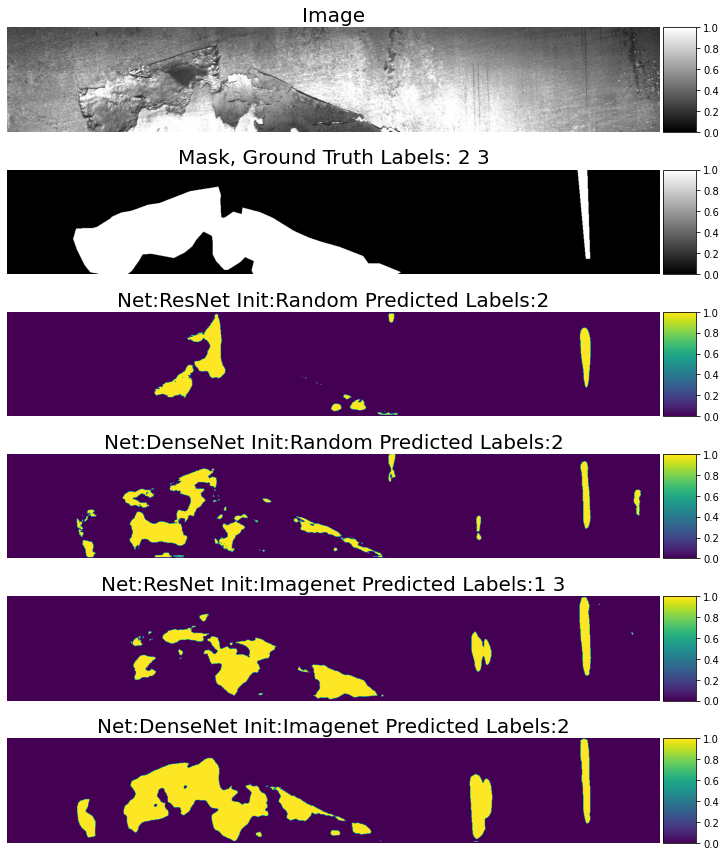

Example 2


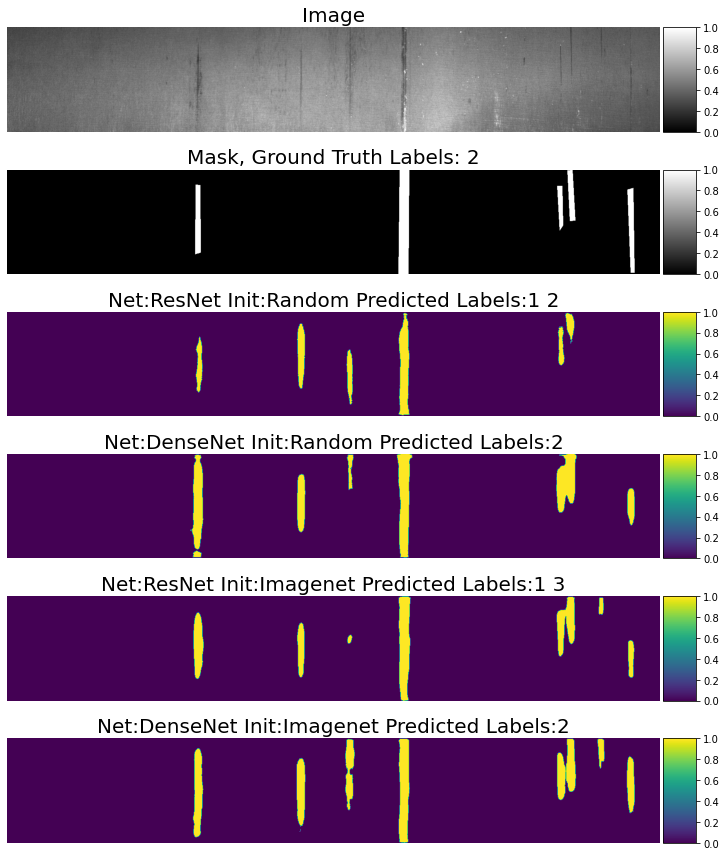

Example 3


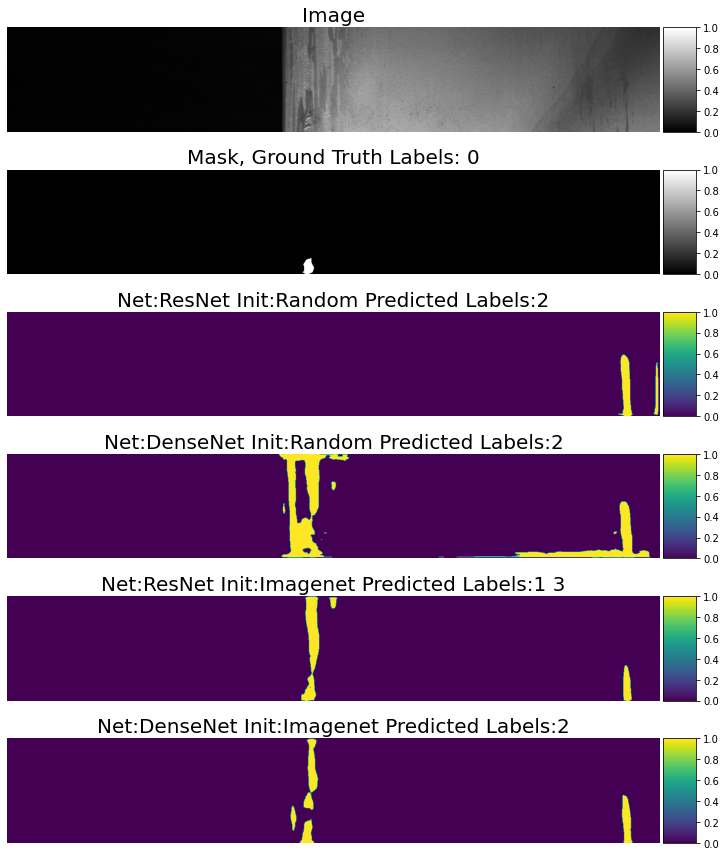

Example 4


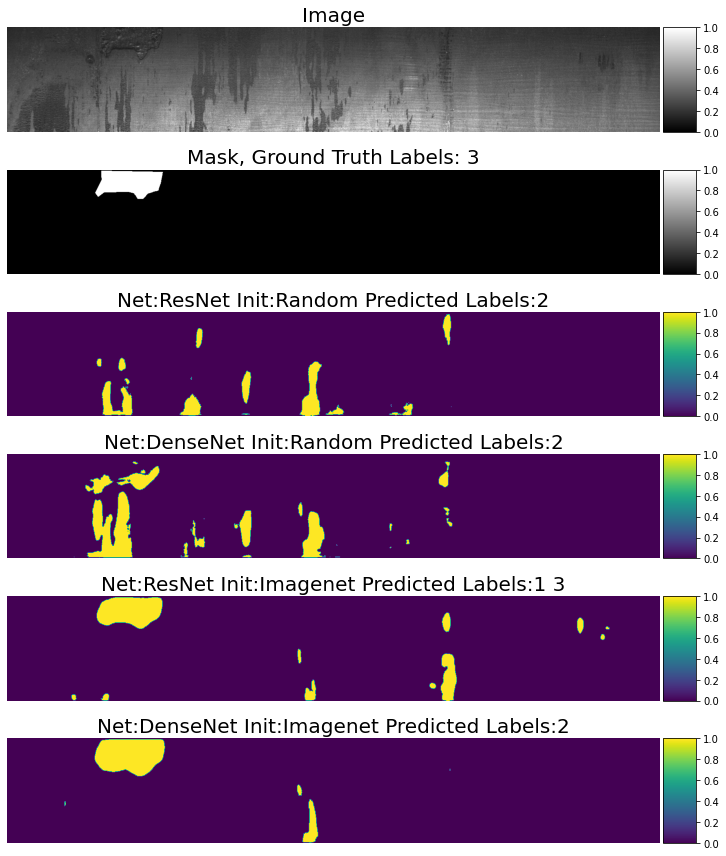

Example 5


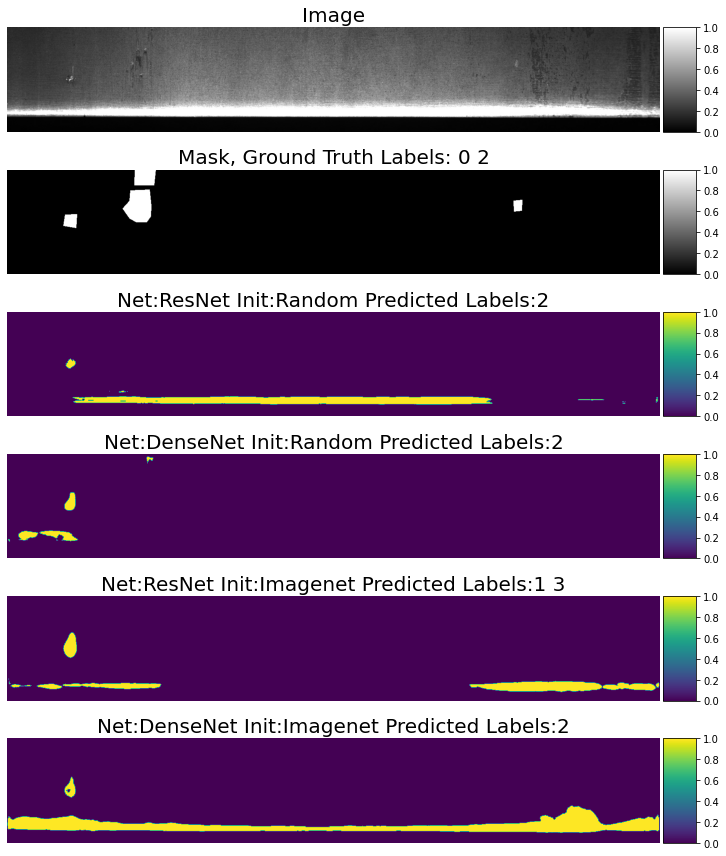

Example 6


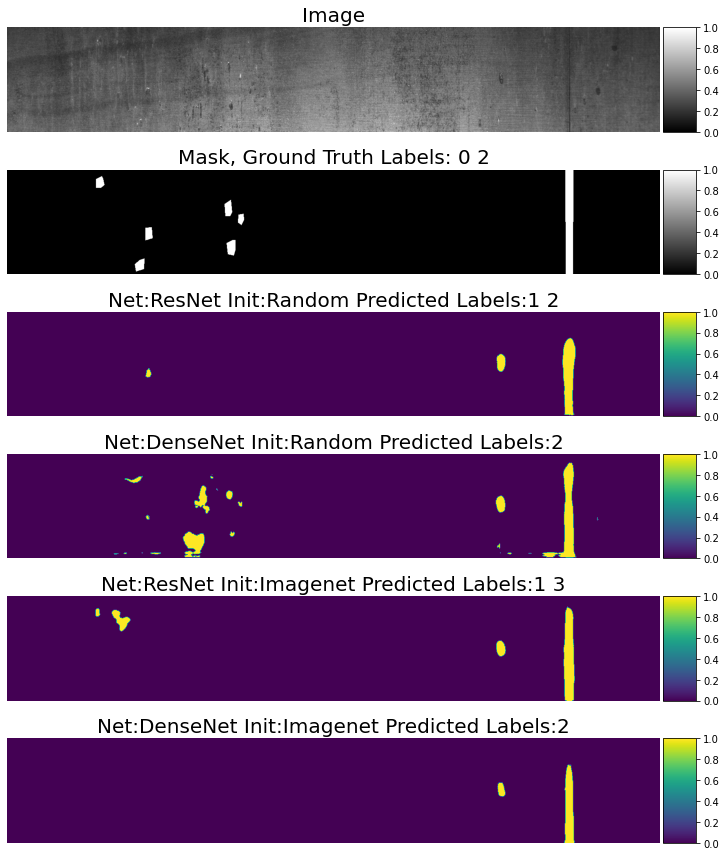

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
run_path='/content/drive/MyDrive/Freelance/FL_Lakshmi/runs2'
df = pd.read_csv('/content/targetdir/train.csv')
df = df.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')
df['defects'] = df.count(axis=1)
train_df, test_val_df = train_test_split(df, test_size=0.25, stratify=df["defects"], random_state=69)
L=round(1.0*train_df.shape[0])
train_df=train_df.iloc[0:L,:]
val_df, test_df = train_test_split(test_val_df, test_size=0.5, random_state=69)
device='cuda'
df = train_df
image_dataset = SteelDataset(df, '/content/targetdir/', mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),phase='test',use_trans=False)
f_s=20
h_fig,w_fig=17,12
cnts=1;
for im_no in [2,5,7,9,142,156]:
    print('Example '+str(cnts))

    cnts=cnts+1
    img,mask=image_dataset.__getitem__(im_no)
    label= (torch.sum(mask,dim=(1,2))>0).float()
    #print('ground truth label')
    #print(np.nonzero(label.numpy()))
    f=plt.figure(figsize=(h_fig,w_fig))
    ax = plt.subplot(6,1,1)
    im=plt.imshow(img/255.0,cmap='gray', vmin=0.0, vmax=1.0)
    plt.title('Image', fontsize=f_s)
    plt.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
   # plt.show();

    #plt.figure(figsize=(h_fig,w_fig))
    ax = plt.subplot(6,1,2)
    gt=np.sum(mask.numpy(),axis=0)
    im=plt.imshow(gt,cmap='gray', vmin=0.0, vmax=1.0)
    lstring=" ".join(str(x) for x in np.nonzero(label.numpy())[0].tolist());
    plt.title('Mask, '+'Ground Truth Labels: '+lstring, fontsize=f_s)
    plt.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
   # plt.show();

    ## 32,_,8,_
    net_types=['resnet18','densenet121'];#,'timm-resnest14d','vgg13_bn'
    net_names = ['ResNet', 'DenseNet']
    init_types=['None','imagenet']
    init_names=['Random','Imagenet']
    percentage_data=[1.0]
    ### model ##
    all_dice={}
    all_iou={}
    inds=3;
    for percentage_idx in range(1):
      for init_idx in range(2):
        for type_idx in range(2):
          run_name=run_path+'/'+net_types[type_idx]+'_'+init_types[init_idx]+'_'+str(percentage_data[percentage_idx])+'/'
          #print(run_name)
          torch.cuda.empty_cache()
          aux_params=dict(
                  pooling='avg',             # one of 'avg', 'max'
                  dropout=0.5,               # dropout ratio, default is None
                  activation=None,      # activation function, default is None
                  classes=4,                 # define number of output labels
              )
          model = smp.Unet(encoder_name=net_types[type_idx],        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
              encoder_weights=None,     # use `imagenet` pretrained weights for encoder initialization
              in_channels=3,                  # model input channels (1 for grayscale images, 3 for RGB, etc.)
              classes=4, activation=None, aux_params=aux_params).to(torch.device("cuda"))
          state=torch.load(run_name+"best_model.pth", map_location=torch.device(device))
          model.load_state_dict(state["state_dict"]);
          model.eval()
          with torch.no_grad():
            _,label_pred=model(img.permute(2,0,1).unsqueeze(0).float().to(device))

          model.train()
          with torch.no_grad():
            mask_pred,_=model(img.permute(2,0,1).unsqueeze(0).float().to(device))
            mask_pred=torch.sigmoid(mask_pred).cpu().numpy()

          tt=np.sum(mask_pred>0.5,axis=1)[0,:,:];
          #plt.figure(figsize=(h_fig,w_fig))
          ax = plt.subplot(6,1,inds)
          im=plt.imshow(tt, vmin=0.0, vmax=1.0)
          label=(torch.sigmoid(label_pred).detach().cpu().numpy()>0.5).astype('float32')[0,:];
          lstring=" ".join(str(x) for x in np.nonzero(label)[0].tolist());

          plt.title('Net:'+net_names[type_idx]+' Init:'+init_names[init_idx]+' Predicted Labels:'+lstring, fontsize=f_s)
          plt.axis('off')
          divider = make_axes_locatable(ax)
          cax = divider.append_axes("right", size="5%", pad=0.05)

          plt.colorbar(im, cax=cax)
          #plt.show()
          inds=inds+1
    plt.tight_layout()
    plt.show();
    #inp=input("Press Enter to continue...")
